# Inverse Distance Weighting (IDW)

The IDW is a deterministic method that predicts values at unsampled locations based on a set of locations at which the values are known. IDW assesses similiarity of values at locations based on an inverse measurement of proximity. That is, closer observed values will have a greater impact on the estimation at a location than further values.

In [65]:
inLibraries = list('repr','rgdal','gstat','sp','spdep','rgeos','maptools',
                       'RColorBrewer','classInt','raster')

for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Read in a digital elevation model (DEM) for Bolivia (bolivia/bolelev.tif) and the country polygon for Bolivia (bolivia/boliviaborder.shp). 

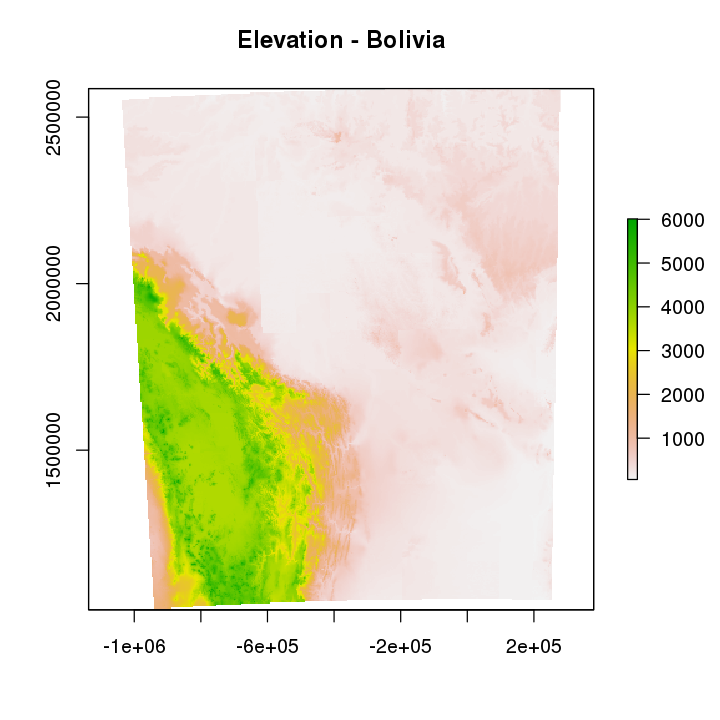

In [66]:
elev <- raster("/dsa/data/geospatial/DS8612/bolivia/bolelev.tif")

plot(elev, main = "Elevation - Bolivia")

In [67]:
res(elev)

[1] 3744.455 3744.455

In [68]:
proj4string(elev)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

In [69]:
bol <- readOGR("/dsa/data/geospatial/DS8612/bolivia",
                             "boliviaborder")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/bolivia", layer: "boliviaborder"
with 1 features
It has 8 fields


In [70]:
summary(bol)

Object of class SpatialPolygonsDataFrame
Coordinates:
       min       max
x -1018795  260396.1
y  1042009 2574906.8
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0
+ellps=aust_SA +units=m +no_defs]
Data attributes:
    OBJECTID     COUNTRY  ISO_CC         CONTINENT        Land_Type   Land_Rank
 Min.   :58   Bolivia:1   BO:1   South America:1   Primary land:1   Min.   :5  
 1st Qu.:58                                                         1st Qu.:5  
 Median :58                                                         Median :5  
 Mean   :58                                                         Mean   :5  
 3rd Qu.:58                                                         3rd Qu.:5  
 Max.   :58                                                         Max.   :5  
   Shape_Leng      Shape_Area   
 Min.   :64.35   Min.   :91.86  
 1st Qu.:64.35   1st Qu.:91.86  
 Median :64.35   Median :91.86  
 Mean   :64.35   Mean   :91.86  
 3rd 

In [71]:
head(bol@data)

,OBJECTID,COUNTRY,ISO_CC,CONTINENT,Land_Type,Land_Rank,Shape_Leng,Shape_Area
0,58,Bolivia,BO,South America,Primary land,5,64.35451,91.86441


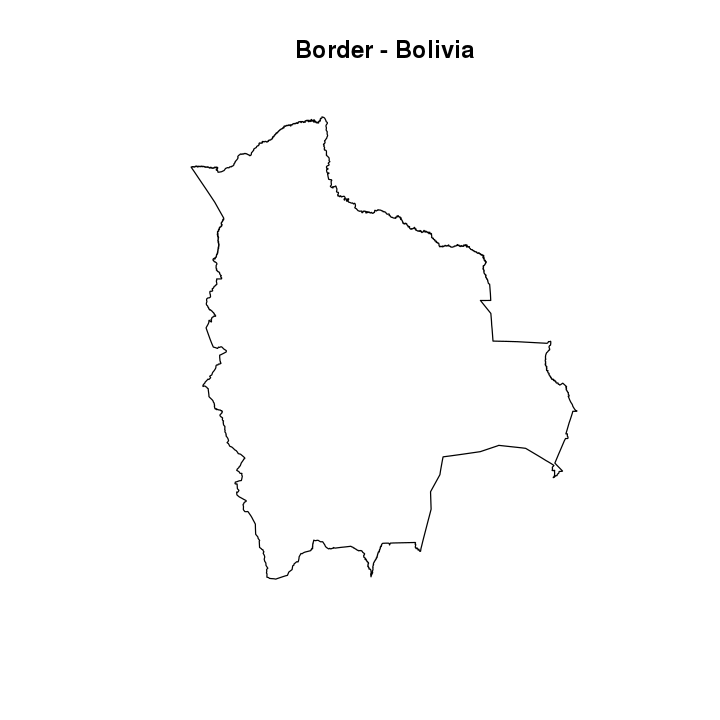

In [72]:
plot(bol, col = "white", main = "Border - Bolivia")

In [73]:
# let's sync up the CRS

elev_CRS <- proj4string(elev)

elev_CRS

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

In [74]:
bol <- spTransform(bol, CRS(elev_CRS))

proj4string(bol)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

Convert the DEM raster cells to a spatialpoints featureclass. 

In [75]:
elev_sp <- rasterToPoints(elev, FUN = null, spatial = TRUE)

In [76]:
summary(elev_sp)

Object of class SpatialPointsDataFrame
Coordinates:
       min       max
x -1036073  278230.4
y  1026192 2583885.4
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0
+ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs]
Number of points: 137303
Data attributes:
    bolelev    
 Min.   :  55  
 1st Qu.: 192  
 Median : 289  
 Mean   :1009  
 3rd Qu.: 999  
 Max.   :6009  

In [77]:
paste("Number of points: ", length(elev_sp))

[1] "Number of points:  137303"

Randomly sample 200 points from the DEM points dataset

In [78]:
numsamples <- 200

dl <- length(elev_sp)
samp.rand <- elev_sp[sample(dl, numsamples), ]
cc <- as.numeric(row.names(samp.rand)) # coordinates

In [79]:
length(samp.rand)

[1] 200

In [80]:
samp.rand[1:5, ]

               coordinates bolelev
18462 (-919995.4, 2377940)     177
29627 (-650394.6, 2258118)     201
31817 (-201059.9, 2235651)     184
79313 (-122426.4, 1711427)     275
60979   (-908762, 1913628)    2999

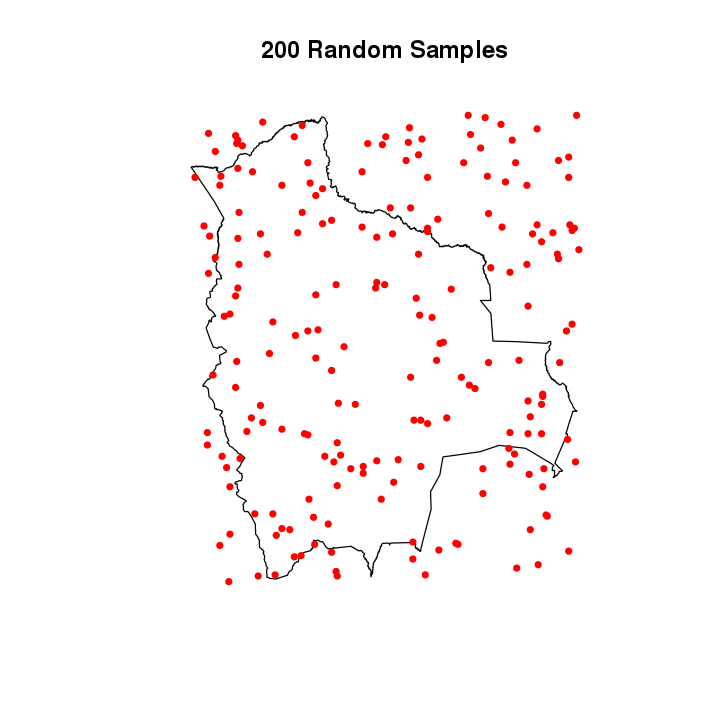

In [81]:
plot(bol, main = "200 Random Samples")
plot(samp.rand, add = TRUE, pch = 20, col = "red")

In [82]:
names(samp.rand)

[1] "bolelev"

In [83]:
head(samp.rand$bolelev)

[1]  177  201  184  275 2999 3195

Create an Interpolation grid dataframe that covers the same extent as the DEM raster. The cellsize of the interpolation grid should be the same as the raster DEM. 

In [84]:
c <- coordinates(elev_sp)

head(c)

x,y
-245993.4,2583885
-242248.9,2583885
-238504.5,2583885
-234760.0,2583885
-231015.6,2583885
-227271.1,2583885


In [85]:
minlon <- min(c[, 1])
maxlon <- max(c[, 1])
minlat <- min(c[, 2])
maxlat <- max(c[, 2])

In [86]:
paste(minlon, "|", maxlon, "|", minlat, "|", maxlat)

[1] "-1036073.46740118 | 278230.371027245 | 1026191.92690126 | 2583885.36503865"

In [87]:
long.range <- as.numeric(c(minlon, maxlon))

long.range

[1] -1036073.5   278230.4

In [88]:
lat.range <- as.numeric(c(minlat, maxlat))

lat.range

[1] 1026192 2583885

In [89]:
cellsize <- 3744 

grd <- expand.grid(x = seq(
                            from = long.range[1],
                            to = long.range[2],
                            by = cellsize),
                   y = seq(
                            from = lat.range[1],
                            to = lat.range[2],
                            by = cellsize))

grd[1:5, ]

x,y
-1036073,1026192
-1032329,1026192
-1028585,1026192
-1024841,1026192
-1021097,1026192


In [90]:
coordinates(grd) <- ~x + y

In [91]:
coordinates(grd)[1:5, ]

,x,y
1,-1036073,1026192
2,-1032329,1026192
3,-1028585,1026192
4,-1024841,1026192
5,-1021097,1026192


In [92]:
gridded(grd) <- TRUE

gridded(grd)

[1] TRUE

In [93]:
proj4string(grd) <- proj4string(elev_sp)

proj4string(grd)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

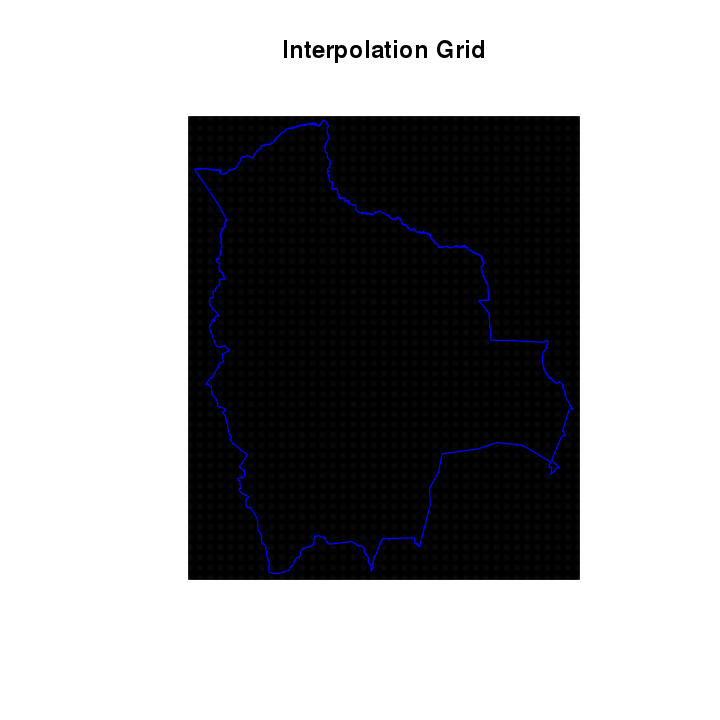

In [94]:
plot(grd, main = "Interpolation Grid")
plot(bol, add = TRUE, border = "blue")

Conduct an IDW using the sampled elevation points. 

Interpolate each cell value based upon the values of it's nearest 1 to 3 sample points within 100 miles and applying a weight of 1.25 to the inverse distance. 


In [95]:
inVa <- samp.rand$bolelev

idw1 <- idw(formula = inVa ~ 1,
               locations = samp.rand, 
               newdata = grd, 
               nmin = 1, nmax = 3, maxdist = 160934, 
               idp = 1.25)

names(idw1)

[inverse distance weighted interpolation]


[1] "var1.pred" "var1.var"

In [96]:
rvals <- idw1@data$var1.pred

rvals[1:5]

[1] 1893.000 1893.000 1893.000 1893.000 1533.432

Warning message in classIntervals(rvals, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”

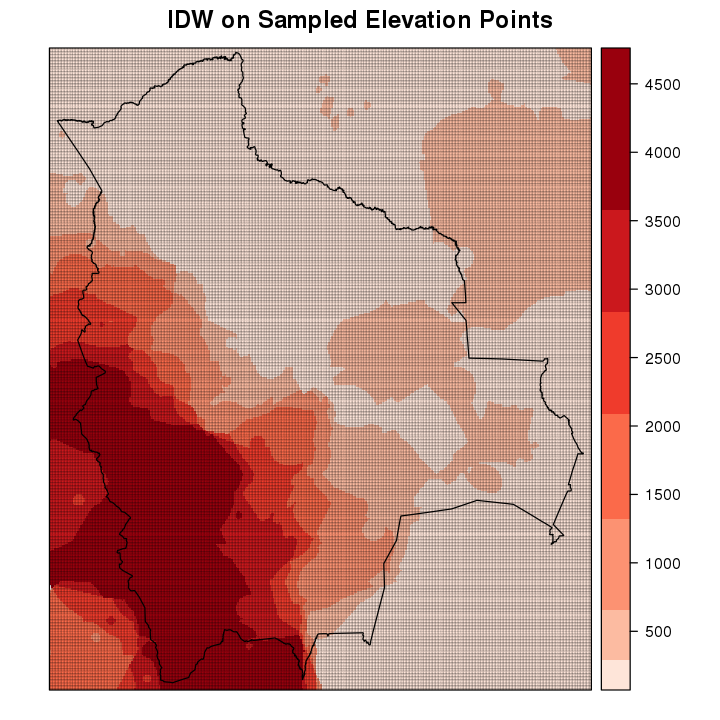

In [97]:
numcat <- 7
cate <- classIntervals(rvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

spplot(idw1["var1.pred"],
          col.regions = color.pal, 
          at = cate$brks, 
          main = "IDW on Sampled Elevation Points",
          panel = function(...) {
              panel.gridplot(..., border = "black")
              sp.polygons(bol)
          })

Given the Western portion of Boliva has more variation in elevation: 

a) sample 100 points from the DEM point dataset assigning higher probability of sampling to points having higher elevations, 

b) combine the points sampled here using inflated probabilities of selection with the 200 randomly selected points obtained earlier (hint: check out the spRbind() function in the maptools library, 

c) map the combined sample of 300 points, overlaying the country polygon and adding an appropriate title.

In [98]:
names(elev_sp)

[1] "bolelev"

In [99]:
# sample 100 points from the DEM point dataset 
# assigning higher probability of sampling to points having higher elevations

n <- 100
N <- length(elev_sp)
pr1 <- c(elev_sp$bolelev) / max(elev_sp$bolelev)

samp.hi <- elev_sp[sample(N, n, replace = TRUE, prob = pr1), ]
dim(samp.hi)

[1] 100   1

In [100]:
samp.combine <- spRbind(samp.hi, samp.rand)
dim(samp.combine)

[1] 300   1

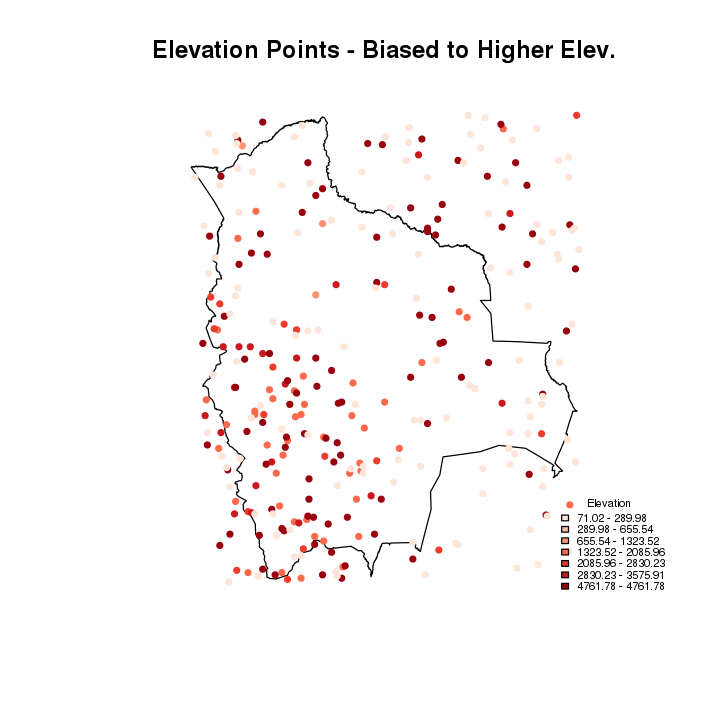

In [101]:
numcat <- 7
q <- classIntervals(samp.combine$bolelev, numcat, style = "kmeans")
pal <- brewer.pal(7, "Reds")
cols <- findColours(cate, pal)

plot(bol, col = "white", main = "Elevation Points - Biased to Higher Elev.")
plot(samp.combine, add = TRUE, pch = 20, col = cols)

brks.dec <- round(cate$brks, 2)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep = " - ")
legend("bottomright", fill = attr(cols, "palette"), 
                   legend = leg.text, bty = "n",
                   title = "Elevation", cex = 0.55)

Conduct an IDW using the combined set of sampled elevation points. Interpolate each cell value based upon the values of it's nearest 1 to 3 sample points within 100 miles and applying a weight of 1.25 to the inverse distance. 

In [102]:
inVa2 <- samp.combine$bolelev

idw2 <- idw(formula = inVa2 ~ 1,
               locations = samp.combine,
               newdata = grd, 
               nmin = 1, nmax = 3, maxdist = 160934, 
               idp = 1.25)

names(idw2)

[inverse distance weighted interpolation]


[1] "var1.pred" "var1.var"

In [103]:
rvals2 <- idw2@data$var1.pred

Warning message in classIntervals(rvals2, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7339050)”

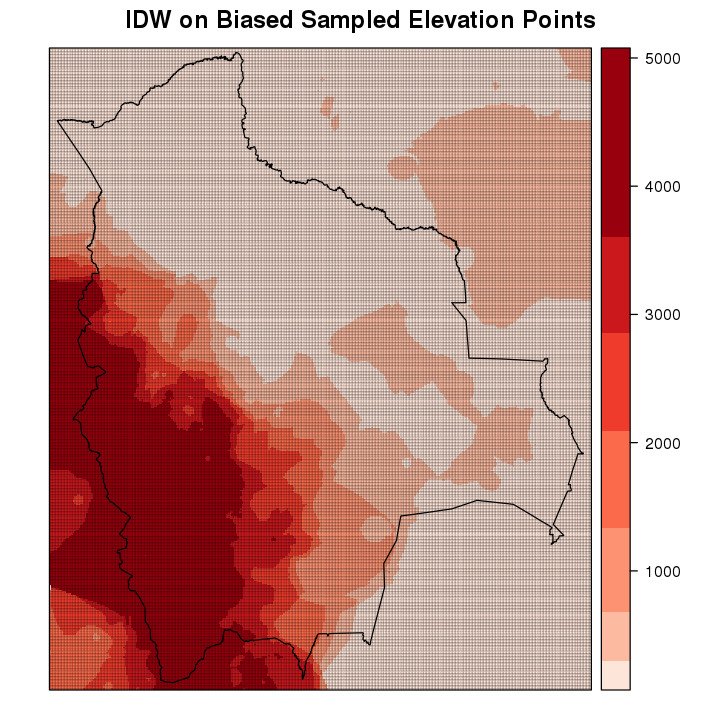

In [104]:
numcat <- 7
cate <- classIntervals(rvals2, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

spplot(idw2["var1.pred"], 
            col.regions = color.pal, 
            at = cate$brks, 
            main = "IDW on Biased Sampled Elevation Points",
            panel = function(...){
                panel.gridplot(..., border = "black")
                sp.polygons(bol)
            })

Convert the predicted values of the two IDW interpolations to raster format.

Then, compute the differences between the two interpolation results. 

Map the differences in IDW interpolations. Be sure to add an appropriate map title.

In [105]:
coordinates(idw1)[1:5, ]

,x,y
1,-1036073,1026192
2,-1032329,1026192
3,-1028585,1026192
4,-1024841,1026192
5,-1021097,1026192


In [106]:
lon1 <- coordinates(idw1)[, 1]
lat1 <- coordinates(idw1)[, 2]
pred1 <- idw1@data$var1.pred

xyz1 <- as.data.frame(cbind(lon1, lat1, pred1))

In [107]:
head(xyz1)

lon1,lat1,pred1
-1036073,1026192,1893.000
-1032329,1026192,1893.000
-1028585,1026192,1893.000
-1024841,1026192,1893.000
-1021097,1026192,1533.432
-1017353,1026192,1537.436


In [108]:
lon2 <- coordinates(idw2)[, 1]
lat2 <- coordinates(idw2)[, 2]
pred2 <- idw2@data$var1.pred

xyz2 <- as.data.frame(cbind(lon2, lat2, pred2))

In [109]:
head(xyz2)

lon2,lat2,pred2
-1036073,1026192,1893.000
-1032329,1026192,1893.000
-1028585,1026192,1893.000
-1024841,1026192,1893.000
-1021097,1026192,1925.180
-1017353,1026192,1927.851


In [110]:
r1 <- rasterFromXYZ(xyz1, crs = CRS(proj4string(elev)))
r2 <- rasterFromXYZ(xyz2, crs = CRS(proj4string(elev)))

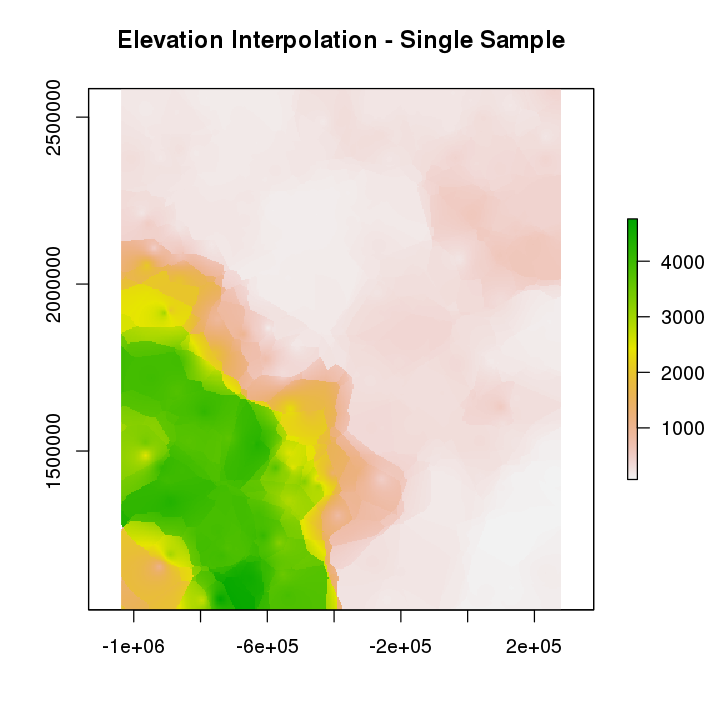

In [111]:
plot(r1, main = "Elevation Interpolation - Single Sample")

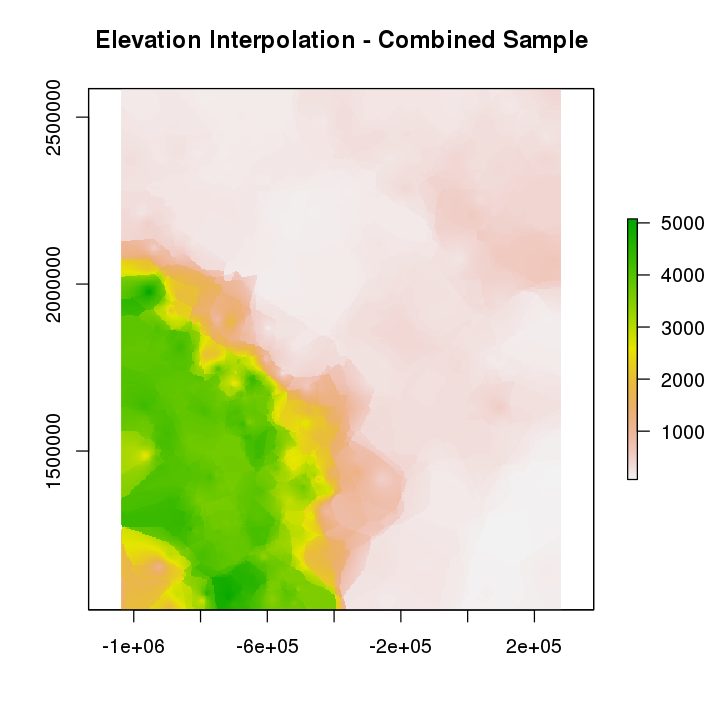

In [112]:
plot(r2, main = "Elevation Interpolation - Combined Sample")

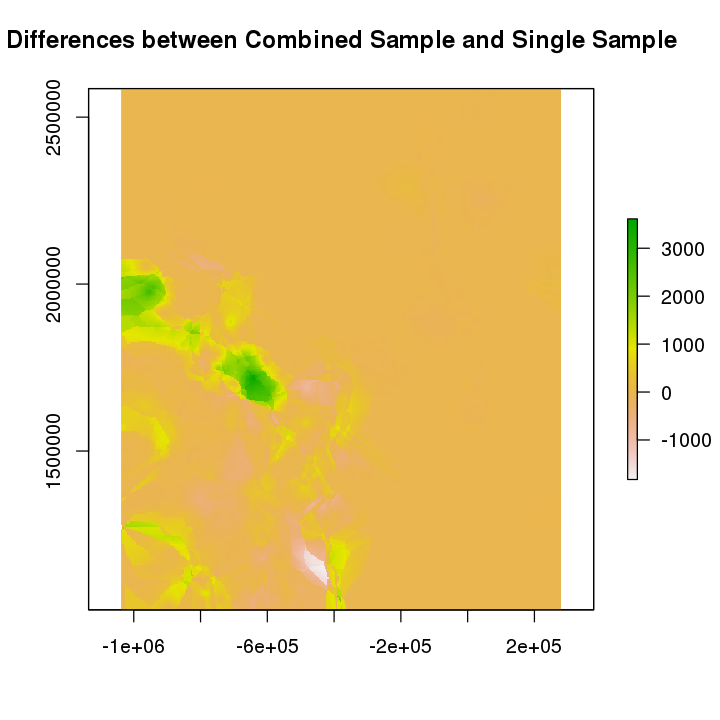

In [113]:
diff <- overlay(r1, r2, fun = function(r1, r2){
    return(r2-r1)
})

plot(diff, main = "Differences between Combined Sample and Single Sample")